In [3]:
import string
import json
import codecs
import re
import praw
import numpy as np
import math
from nltk.stem import WordNetLemmatizer
from langdetect import detect, DetectorFactory

from collections import Counter
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
nltk.download('vader_lexicon') 
nltk.download('wordnet')

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Chelsea/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Chelsea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data description

In [4]:
# load json file
fJsonName_reddit = 'olympics_posts_reddit.json'
fJsonName_youtube = 'NEW_youtube_olympics_data_limited_250_per_hashtag.json'

#extract data -reddit
post_data_reddit =[]
# open json file and process it tweet by tweet
with open(fJsonName_reddit, 'r') as f:
    dSubmissions = json.load(f)
    
    for submission in dSubmissions:
        submissionID = submission['id']
        submissionName = submission['keyword']
        submissionsTitle = submission['title']
        submissionSelftext = submission['selftext']
        submissionCreated = submission['created']

        # store all process data
        post_data_reddit.append({
            'ID': submissionID,
            'Subreddit' : submissionName,
            'Title': submissionsTitle,
            'Selftext': submissionSelftext,
            'Created': submissionCreated
        })

# Convert a DataFrame
df_post_data_reddit = pd.DataFrame(post_data_reddit)
# change datetime
df_post_data_reddit['Created'] = pd.to_numeric(df_post_data_reddit['Created'], errors='coerce')
df_post_data_reddit['Created'] = pd.to_datetime(df_post_data_reddit['Created'], unit='s')

In [5]:
# Extract comments of reddit
comments_data_reddit = []
for post in dSubmissions:
    submission_id = post['id']
    for comment in post['comments']:
        # Include submission ID to link comments to their posts
        comments_data_reddit.append({
            'submissionID': submission_id,
            'commentID': comment['id'],
            'commentBody': comment['body'],
            'Created': comment['created']
        })
# Convert a DataFrame
df_comments_data_reddit = pd.DataFrame(comments_data_reddit)
df_comments_data_reddit['Created'] = pd.to_numeric(df_comments_data_reddit['Created'], errors='coerce')
df_comments_data_reddit['Created'] = pd.to_datetime(df_comments_data_reddit['Created'], unit='s')
print(df_comments_data_reddit)

       submissionID commentID  \
0           1er8uik   lhxbug8   
1           1er8uik   lhx5ejr   
2           1er8uik   lhy3e0l   
3           1er8uik   lhx9nqm   
4           1er8uik   lhx0zgh   
...             ...       ...   
200611       viebgm   iddjjz7   
200612       viebgm   iddne1h   
200613       viebgm   iddiwjz   
200614       viebgm   ide82w7   
200615       viebgm   iddptq5   

                                              commentBody             Created  
0       ![gif](giphy|1KHBPmEOkv0B2)\n\nPOV: top right ... 2024-08-13 15:41:17  
1       I just want to know what's in the top corner o... 2024-08-13 15:07:45  
2       I cant believe that this person became\nthe fo... 2024-08-13 18:05:09  
3       Media is more upset about this than the fact t... 2024-08-13 15:29:55  
4       Nobody said anything when she lost in the quar... 2024-08-13 14:44:16  
...                                                   ...                 ...  
200611       Well said, I agree with everyt

In [6]:
#Extract Youtube data
post_data_youtube =[]
# open json file and process it tweet by tweet
with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)
    
    for submission in ySubmissions:
        submissionHashtag = submission['Hashtag']
        submissionDescription = submission['Description']
        submissionsTitle = submission['Video Title']
        submissionCreated = submission['Publish Time']

        # store all process data
        post_data_youtube.append({
            'Hashtag': submissionHashtag,
            'Description' : submissionDescription,
            'Title': submissionsTitle,
            'Created': submissionCreated
        })

# Convert a DataFrame
df_post_data_youtube= pd.DataFrame(post_data_youtube)
df_post_data_youtube['Created'] = pd.to_datetime(df_post_data_youtube['Created'], errors='coerce')
df_post_data_youtube

,Hashtag,Description,Title,Created
0,#paris2024,Re-live ALL the incredible #Paris2024 action: ...,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,2024-08-03 21:54:16+00:00
1,#paris2024,This is how to Travel Paris and leave LOVING i...,How to Spend 3 Days in Paris (2024 Travel Itin...,2024-07-06 13:00:31+00:00
2,#paris2024,Paris has never seen a love like this. The Oly...,Paris 2024 Olympic Games | Official Trailer -...,2024-07-17 12:18:28+00:00
3,#paris2024,Re-live ALL the incredible #Paris2024 action: ...,THANK YOU PARIS! Closing Ceremony Highlights |...,2024-08-11 23:31:08+00:00
4,#paris2024,Watch all the #Paris2024 action LIVE! ➡️ https...,LET THE GAMES BEGIN! 🔥 | #Paris2024 Opening Ce...,2024-07-27 01:49:50+00:00
...,...,...,...,...
745,#rio2016,J-7 avant #Tokyo2020 Retrouve tous les jours L...,#Rio2016 - Emilie Andéol Finale Judo +78kg,2021-07-16 12:17:08+00:00
746,#rio2016,Re-live ALL the incredible #Paris2024 action ➡...,Women&#39;s Individual All-Around Final - Arti...,2016-08-22 02:30:48+00:00
747,#rio2016,Score : 5.6 + 7.366: 12.966 Olympics Rio.,Rebeca Andrade FX Team Final Rio 2016,2020-05-22 03:34:12+00:00
748,#rio2016,Subscribe to @olympics: http://oly.ch/Subscrib...,Matthias Steiner wins an emotional gold at Bei...,2015-12-29 09:00:00+00:00


In [7]:
# Extract comments of Youtube
comments_data_youtube = []
for post in ySubmissions:
    submissions_Title = post['Video Title']
    for comment in post['Comments']:
        # Include submission ID to link comments to their posts
        comments_data_youtube.append({
            'submissionTitle': submissions_Title,
            'commentText': comment['text'],
            'commentAuthor': comment['author'],
            'Created': comment['published_at']
        })
# Convert a DataFrame
df_comments_data_youtube = pd.DataFrame(comments_data_youtube)
df_comments_data_youtube['Created'] = pd.to_datetime(df_comments_data_youtube['Created'], errors='coerce')
df_comments_data_youtube

,submissionTitle,commentText,commentAuthor,Created
0,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,Christina Lakes,@GeraldMasse-y7l,2024-10-10 01:44:41+00:00
1,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,Hegmann Ranch,@MacKelly-j3n,2024-10-09 20:00:48+00:00
2,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,Harvey Overpass,@MargaretDavis-b9h,2024-10-08 13:44:28+00:00
3,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,Kub Avenue,@CurtisKirkland-x7k,2024-10-08 05:10:02+00:00
4,Julien Alfred takes Gold 🥇 Women&#39;s 100m Fi...,Georgianna Viaduct,@LuciusDierser-n6r,2024-10-07 18:11:57+00:00
...,...,...,...,...
444769,Rio 2016 Olympic Torch Relay - Behind the scen...,cool,@davidtheboss_dn6879,2016-06-24 13:10:56+00:00
444770,Rio 2016 Olympic Torch Relay - Behind the scen...,Super cool! I'm looking forward the beginning ...,@aurylovevintage2198,2016-06-24 10:54:21+00:00
444771,Rio 2016 Olympic Torch Relay - Behind the scen...,I don't see a dead jaguar anywhere. Hmmm,@mr_teo4072,2016-06-24 10:54:09+00:00
444772,Rio 2016 Olympic Torch Relay - Behind the scen...,"i dont understand how this is ""behind the scen...",@TonyBerten,2016-06-24 08:57:10+00:00


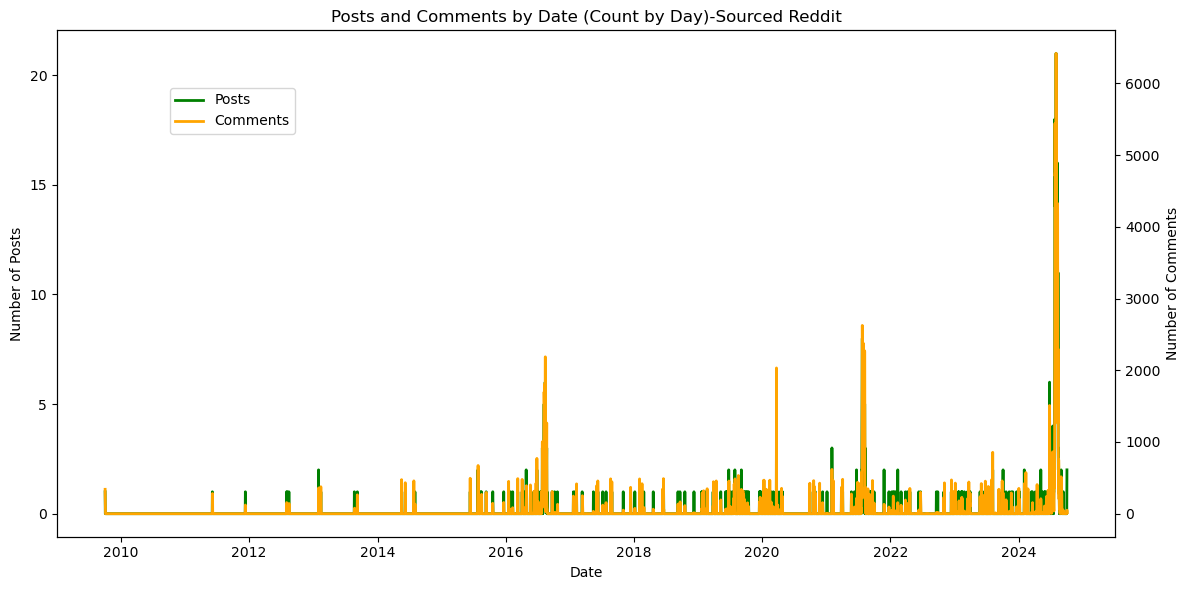

In [8]:
# Posts/comments for daily resample-Reddit data
df_post_data_reddit_day = df_post_data_reddit.resample('24h', on='Created').size()
df_comments_data_reddit_day = df_comments_data_reddit.resample('24h', on='Created').size()

# Create a figure and a single set of axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot posts on the primary y-axis
ax1.plot(df_post_data_reddit_day.index, df_post_data_reddit_day, color='green', label='Posts', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Posts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Posts and Comments by Date (Count by Day)-Sourced Reddit')

# Create a secondary y-axis to plot comments
ax2 = ax1.twinx()  
ax2.plot(df_comments_data_reddit_day.index, df_comments_data_reddit_day, color='orange', label='Comments', linewidth=2)
ax2.set_ylabel('Number of Comments', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Adjust layout to ensure everything fits well
plt.tight_layout()
# Show the combined plot
plt.show()



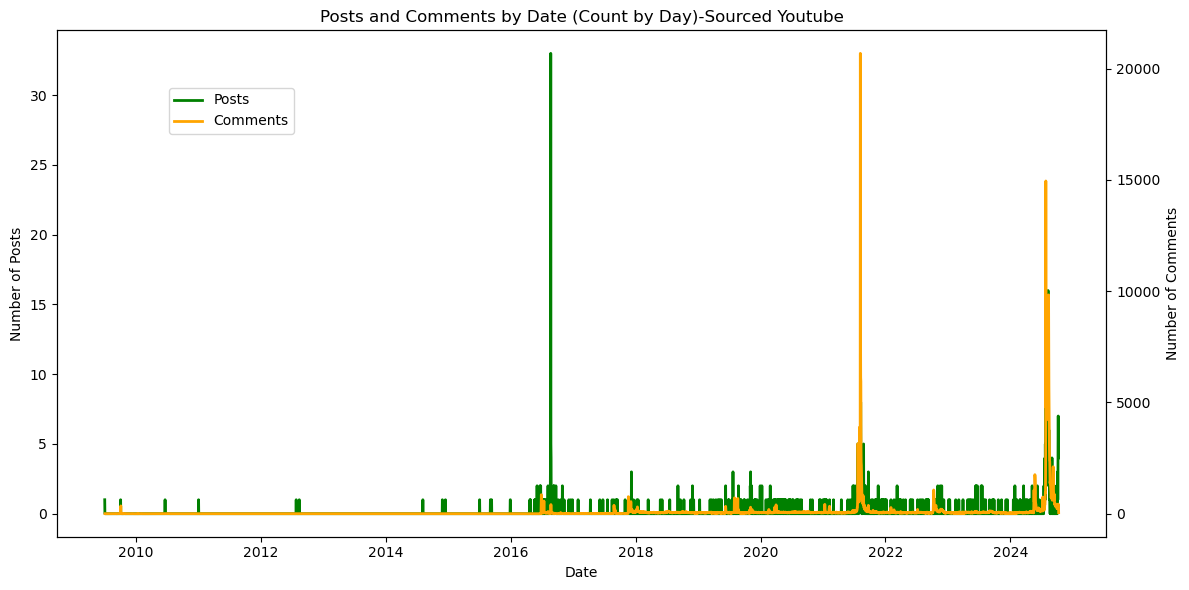

In [9]:
# Posts/comments for daily resample-Youtube data
df_post_data_youtube_day = df_post_data_youtube.resample('24h', on='Created').size()
df_comments_data_youtube_day = df_comments_data_youtube.resample('24h', on='Created').size()

# Create a figure and a single set of axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot posts on the primary y-axis
ax1.plot(df_post_data_youtube_day.index, df_post_data_youtube_day, color='green', label='Posts', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Posts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Posts and Comments by Date (Count by Day)-Sourced Youtube')

# Create a secondary y-axis to plot comments
ax2 = ax1.twinx()  
ax2.plot(df_comments_data_youtube_day.index, df_comments_data_youtube_day, color='orange', label='Comments', linewidth=2)
ax2.set_ylabel('Number of Comments', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Adjust layout to ensure everything fits well
plt.tight_layout()
# Show the combined plot
plt.show()

In [39]:
# reddit/youtube plots

def plot_combined_posts_comments(df_post_data_1, df_comments_data_1, df_post_data_2, df_comments_data_2, platform1_name, platform2_name):
    """
    Plot combined posts and comments data for two platforms in subplots.

    Args:
    df_post_data_1 (DataFrame): Posts data for platform 1.
    df_comments_data_1 (DataFrame): Comments data for platform 1.
    df_post_data_2 (DataFrame): Posts data for platform 2.
    df_comments_data_2 (DataFrame): Comments data for platform 2.
    platform1_name (str): Name of the first platform (e.g., 'Reddit').
    platform2_name (str): Name of the second platform (e.g., 'YouTube').
    """

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot posts and comments for Platform 1
    ax1.plot(df_post_data_1.index, df_post_data_1, color='green', label='Posts', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Posts', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(f'Posts and Comments by Date (Count by Day) - {platform1_name}')
    
    ax1_2 = ax1.twinx()  # Secondary y-axis for comments
    ax1_2.plot(df_comments_data_1.index, df_comments_data_1, color='orange', label='Comments', linewidth=2)
    ax1_2.set_ylabel('Number of Comments', color='black')
    ax1_2.tick_params(axis='y', labelcolor='black')

    # Add legends for Platform 1
    ax1.legend(['Posts'], loc='upper left')
    ax1_2.legend(['Comments'], loc='upper right')

    # Plot posts and comments for Platform 2
    ax2.plot(df_post_data_2.index, df_post_data_2, color='green', label='Posts', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Posts', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_title(f'Posts and Comments by Date (Count by Day) - {platform2_name}')
    
    ax2_2 = ax2.twinx()  # Secondary y-axis for comments
    ax2_2.plot(df_comments_data_2.index, df_comments_data_2, color='orange', label='Comments', linewidth=2)
    ax2_2.set_ylabel('Number of Comments', color='black')
    ax2_2.tick_params(axis='y', labelcolor='black')

    # Add legends for Platform 2
    ax2.legend(['Posts'], loc='upper left')
    ax2_2.legend(['Comments'], loc='upper right')

    # Adjust layout to ensure everything fits well
    plt.tight_layout()

    # Show the combined plot with two subplots
    plt.show()


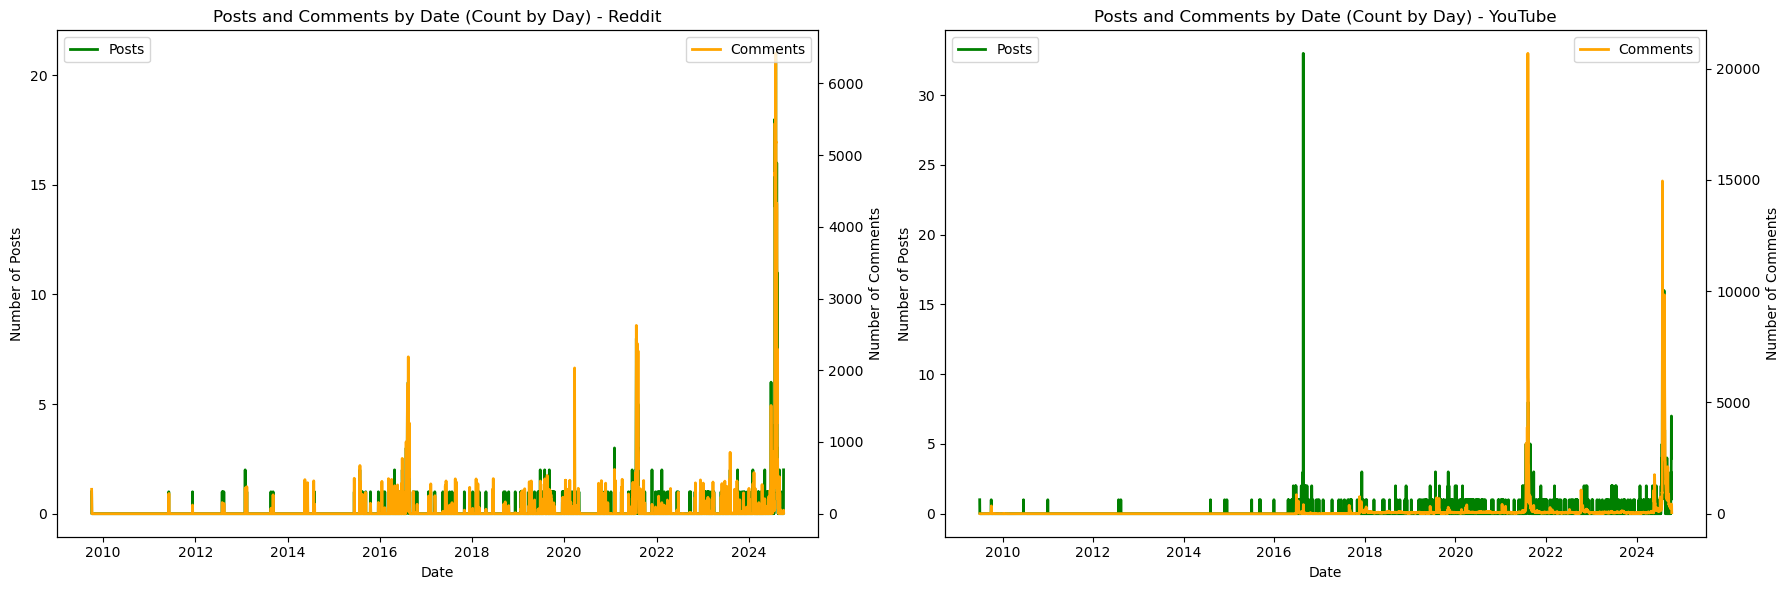

In [40]:
plot_combined_posts_comments(
    df_post_data_reddit_day, df_comments_data_reddit_day,
    df_post_data_youtube_day, df_comments_data_youtube_day,
    'Reddit', 'YouTube'
)

## Lemmatisation approach - reddit

In [12]:
def processText_lem(text, tokenizer, stemmer, stopwords):
    """
    Perform tokenisation, normalisation (lower case and lemmatization) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = [stemmer.lemmatize(tok.strip(), pos = 'v') for tok in lTokens]

    # pattern for digits
    # the list comprehension in return statement essentially remove all strings of digits or fractions, e.g., 6.15
    regexDigit = re.compile(r"^\d+\s|\s\d+\s|\s\d+$")
    # regex pattern for http
    regexHttp = re.compile("^http")

    # remove stopwords, digits/urls
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit() and regexHttp.match(tok) == None]

In [41]:
# number of most frequent terms to display
freqNum = 50

# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`','.',"’",'-',"it'","i'm","i've","that's"]
# we use the lemmatisation approach
tweetStemmer_lem = WordNetLemmatizer()
# our term frequency counter
termFreqCounter = Counter()
    
for submission in dSubmissions:
    submissionID = submission['id']
    submissionsTitle = submission['title']
    submissionSelftext = submission['selftext']
    submissionCreated = submission['created']
    
    # tokenise, filter stopwords and get convert to lower case
    lTokens = processText_lem(text=submissionsTitle + ' ' + submissionSelftext , 
                              tokenizer=tweetTokeniser, 
                              stemmer=tweetStemmer_lem, 
                              stopwords=lStopwords)

    # update count
    termFreqCounter.update(lTokens)
    # process the comments
    for comment in submission['comments']:
        commentText = comment['body']
        commentCreate = comment['created']
        
        lTokens = processText_lem(text=commentText, 
                                  tokenizer=tweetTokeniser, 
                                  stemmer=tweetStemmer_lem, 
                                  stopwords=lStopwords)
        termFreqCounter.update(lTokens)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))
    # most common terms dataframe
    cmterms_reddit = pd.DataFrame(termFreqCounter.most_common(freqNum),columns=['Term', 'Count']) 

get: 23198
like: 22177
olympics: 17475
go: 16306
would: 15770
think: 14629
make: 14131
one: 14099
people: 13716
time: 12402
win: 12245
say: 11609
even: 11390
team: 11370
see: 11098
game: 10576
know: 10317
sport: 10175
play: 9186
good: 9014
really: 8812
also: 8668
look: 8428
gold: 7928
us: 7928
still: 7686
much: 7611
well: 7590
take: 7582
olympic: 7545
medal: 7282
want: 7232
world: 7117
watch: 6727
need: 6720
could: 6565
fuck: 6545
come: 6388
way: 6202
athletes: 6166
give: 6143
use: 6143
right: 6128
years: 5938
best: 5900
first: 5681
guy: 5641
point: 5593
mean: 5339
better: 5302


# Lemmatisation aproach - Youtube

In [42]:
# https://www.sdhilip.com/text-preprocessing-for-data-scientists/
# https://medium.com/@monigrancharov/text-language-detection-with-python-beb49d9667b3

# Set seed for consistency in results
DetectorFactory.seed = 0

def processText_lem_youtube(text, tokenizer, stemmer, stopwords, language = 'en'):
    """
    Perform tokenisation, normalisation (lower case and lemmatization) and stopword and twitter keyword removal.

    @param text: reddit submission or comment text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """
    # detect language and only proceed if the text is in the target language
    try:
        detected_language = detect(text)
    except:
        return []  # it will return empty list if language detection fails

    if detected_language != language:
        return []  # it will return empty list if the text is not in the target language
        
    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = [stemmer.lemmatize(tok, pos = 'v') for tok in lTokens]
    
    regexHttp = re.compile("^http")
    regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
    regexhash = re.compile(r"^(#|@)")

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # remove emojis from tokens
    lStemmedTokens = [emoji_pattern.sub(r'', tok) for tok in lStemmedTokens]

    return [tok for tok in lStemmedTokens if tok not in stopwords and 
            not tok.isdigit() and 
            tok and
            regexHttp.match(tok) == None and 
            regexDigit.match(tok) == None and
            regexhash.match(tok) == None]

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
/var/folders/lq/wst6txn15xb88w382y5y1th40000gn/T/ipykernel_16261/3709243961.py:37: SyntaxWarning: invalid escape sequence '\d'
  regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")


In [43]:
# number of most frequent terms to display
freqNum = 50

# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', " ","➡",'via','@','#', '...','..', '…', "sure",'"', "'", '`','.',"’",
                                                                '-',"it'","i'm","i've"]
# we use the lemmatisation approach
tweetStemmer_lem = WordNetLemmatizer()
# our term frequency counter
termFreqCounter = Counter()

with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)
    
    for submission in ySubmissions:
        submissionDescription = submission['Description']
        submissionsTitle = submission['Video Title']
        
        # tokenise, filter stopwords and get convert to lower case
        lTokens = processText_lem_youtube(text=submissionDescription + ' ' + submissionsTitle, 
                                  tokenizer=tweetTokeniser, 
                                  stemmer=tweetStemmer_lem, 
                                  stopwords=lStopwords)
    
        # update count
        termFreqCounter.update(lTokens)
        # process the comments
        for comment in submission['Comments']:
            commentText = comment['text']
            
            lTokens = processText_lem_youtube(text=commentText, 
                                      tokenizer=tweetTokeniser, 
                                      stemmer=tweetStemmer_lem, 
                                      stopwords=lStopwords)
            termFreqCounter.update(lTokens)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))
    # most common terms dataframe
    cmterms_youtube = pd.DataFrame(termFreqCounter.most_common(freqNum),columns=['Term', 'Count']) 

olympics: 17831
like: 16179
love: 14006
get: 12736
proud: 12363
congratulations: 11681
india: 11607
olympic: 11349
make: 10925
gold: 10649
go: 10164
one: 10101
win: 9794
see: 9597
game: 9219
watch: 9143
people: 9110
best: 8714
time: 8700
know: 8327
look: 7907
world: 7875
song: 7722
team: 6852
think: 6714
great: 6607
sport: 6520
paris: 6333
would: 6185
even: 6064
france: 5965
say: 5912
medal: 5907
come: 5791
athletes: 5766
really: 5756
country: 5747
thank: 5743
well: 5373
neeraj: 5350
video: 5267
much: 5253
indian: 5216
amaze: 4937
japan: 4861
tokyo: 4782
ever: 4756
open: 4729
give: 4595
need: 4549


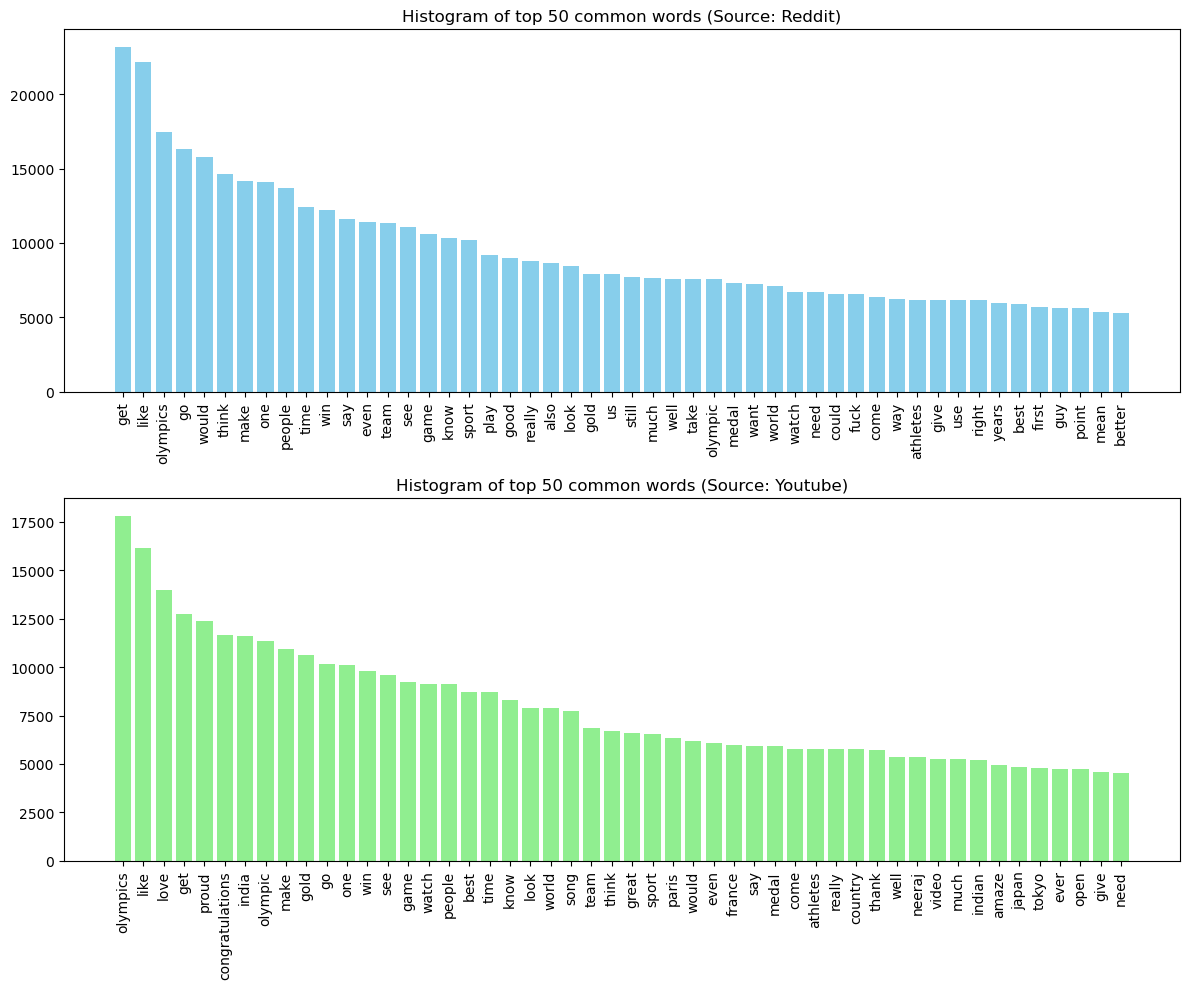

In [44]:
# Create a figure with two subplots in two rows
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 1 row, 2 columns

# First histogram (top)
axes[0].bar(cmterms_reddit['Term'], cmterms_reddit['Count'], color='skyblue')
axes[0].set_title('Histogram of top 50 common words (Source: Reddit)')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels


# Second histogram (bottom)
axes[1].bar(cmterms_youtube['Term'], cmterms_youtube['Count'], color='lightgreen')
axes[1].set_title('Histogram of top 50 common words (Source: Youtube)')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels


# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the combined plots
plt.show()